#  Análise de CSAT - Customer Experience (Dezembro/2025)

**Case Técnico:** Data Science & Customer Experience  
**Período analisado:** Dezembro de 2025  
**Meta projetada:** Janeiro de 2026  
**Autor:** Isaque  
**Data:** 03/02/2026

---

##  Contexto do Negócio

Este notebook contém a análise completa do desempenho de atendimento ao cliente de uma empresa de E-commerce durante dezembro de 2025. A diretoria de Customer Experience precisa:

1. **Diagnosticar** a situação atual do CSAT
2. **Avaliar** a viabilidade da meta projetada para janeiro/2026
3. **Propor** ações baseadas em dados para melhoria do indicador

### Metodologia

- **CSAT (Top 2 Box):** Percentual de notas 4 e 5
- **Meta Ponderada:** Calculada pelo mix de motivos de dezembro
- **Análise Estatística:** Correlação de Spearman para reincidência
- **NLP:** KeyBERT + Sentence-BERT para análise semântica dos comentários

### Bases de Dados

1. **base_1_tickets.csv** - Avaliações de CSAT (10.000 tickets com resposta)
2. **base_2_historico.csv** - Volumetria total de contatos
3. **base_3_metas.csv** - Metas por motivo para Janeiro/2026

---

##  1. Carregamento e Preparação dos Dados

In [3]:
# Importar bibliotecas
import pandas as pd

# Carregar dados
tickets = pd.read_csv('../dados/base_1_tickets.csv', sep=";")
historico = pd.read_csv('../dados/base_2_historico.csv', sep=";")
metas = pd.read_csv('../dados/base_3_metas.csv', sep=";")

# Converter datas
tickets['data_contato'] = pd.to_datetime(tickets['data_contato'])
historico['data_contato'] = pd.to_datetime(historico['data_contato'])

# Tratar coluna meta_mes (vem como "jan'26")
metas['meta_mes'] = metas['meta_mes'].replace("jan'26", "2026-01-01")
metas['meta_mes'] = pd.to_datetime(metas['meta_mes'])

---

#  2. Diagnóstico Atual (Item 4.1)

## 2.1 CSAT Geral de Dezembro

Utilizando a metodologia **Top 2 Box**, calculamos o percentual de clientes que avaliaram o atendimento com notas 4 ou 5.

In [4]:
# Filtrar dezembro/2025
tickets_dez = tickets[
    (tickets['data_contato'].dt.year == 2025) &
    (tickets['data_contato'].dt.month == 12)
].copy()

# Calcular CSAT (Top 2 Box: % de notas 4 e 5)
tickets_dez['csat_positivo'] = tickets_dez['csat'].isin([4, 5]).astype(int)
csat_geral = tickets_dez['csat_positivo'].mean()

print(f"CSAT Geral: {csat_geral:.2%}")
csat_geral

np.float64(0.546)

## 2.2 Principais Ofensores

Identificamos os motivos que combinam **alto volume** de contatos com **baixo CSAT**, pois estes têm maior impacto no indicador geral.

**Critério:** Motivos com volume acima da mediana E CSAT abaixo da mediana.

In [ ]:
# Agrupar por motivo: volume e CSAT médio
csat_por_motivo = tickets_dez.groupby('motivo_contato').agg(
    volume=('ticket_id', 'count'),
    csat_top2=('csat_positivo', 'mean'),
    csat_medio=('csat', 'mean')
).reset_index()
# Calcular medianas para identificar ofensores
volume_mediana = csat_por_motivo['volume'].median()
csat_mediana = csat_por_motivo['csat_top2'].median()

csat_por_motivo

Os valores exibidos na primeira coluna correspondem ao índice do DataFrame, utilizado internamente pelo pandas para identificação das linhas, não representando uma variável de negócio. Sendo relevante apenas para fins de referência dentro do contexto do DataFrame.

In [6]:
# Ofensores = Alto volume + Baixo CSAT
ofensores = csat_por_motivo[
    (csat_por_motivo['volume'] > volume_mediana) &
    (csat_por_motivo['csat_top2'] < csat_mediana)
].sort_values('volume', ascending=False)

ofensores

,motivo_contato,volume,csat_top2,csat_medio
7,Confirmação de pagamento,368,0.516304,3.339674
9,Cupom de desconto inválido,352,0.505682,3.343750
11,Dúvida sobre frete,344,0.534884,3.453488
24,Rastreamento não atualiza,340,0.544118,3.423529
17,Estorno não realizado,340,0.526471,3.355882
25,Reclamação sobre transportadora,339,0.533923,3.353982
1,Alteração de dados cadastrais,338,0.538462,3.417160


A tabela acima destaca os **7 motivos críticos** que devem ser o foco do plano de ação.
Observe que motivos como **"Cupom de desconto inválido"** e **"Confirmação de pagamento"** possuem os piores índices de satisfação (CSAT ~50-51%), bem abaixo da média geral.

## 2.3 Correlação entre Reincidência e Satisfação

Analisamos se clientes que entram em contato múltiplas vezes apresentam satisfação diferente dos clientes que contatam apenas uma vez.

**Hipótese:** Reincidência pode indicar falha na resolução de primeira chamada (FCR), impactando negativamente o CSAT.

In [7]:
# Filtrar histórico de dezembro
historico_dez = historico[
    (historico['data_contato'].dt.year == 2025) &
    (historico['data_contato'].dt.month == 12)
].copy()

# Contar quantos contatos cada cliente teve
reincidencia = historico_dez.groupby('id_cliente').size().reset_index(name='qtd_contatos')

# Juntar com tickets para análise
tickets_reinc = tickets_dez.merge(reincidencia, on='id_cliente', how='left')

# Correlação de Spearman (não-paramétrica)
from scipy.stats import spearmanr
corr, p_value = spearmanr(tickets_reinc['qtd_contatos'], tickets_reinc['csat'])

print(f"Correlação Spearman: {corr:.4f} (p-value: {p_value:.4f})")

Correlação Spearman: -0.0009 (p-value: 0.9249)


O coeficiente de Spearman próximo de zero indica que não há uma correlação linear direta simples entre o número de contatos e a nota.
No entanto, a relação pode não ser linear. Para investigar melhor, vamos agrupar os contatos em **faixas de reincidência** e observar o comportamento do CSAT médio em cada grupo.

In [8]:
# Criar faixas de reincidência

tickets_reinc['faixa_contatos'] = pd.cut(
    tickets_reinc['qtd_contatos'],
    bins=[0, 1, 2, 3, 5, 10],
    labels=['1', '2', '3', '4-5', '6+']
)

tickets_reinc.groupby('faixa_contatos')['csat'].mean()

faixa_contatos
1      3.444968
2      3.303030
3      3.525253
4-5    3.459313
6+     3.452811
Name: csat, dtype: float64

A análise de CSAT por motivo evidencia que os principais ofensores não são apenas aqueles com pior avaliação média, mas aqueles que combinam alto volume de contatos com baixos índices de satisfação, amplificando seu impacto no resultado global do indicador.

---

# 🎯 3. Análise de Viabilidade da Meta

## 3.1 Cálculo da Meta Geral Projetada

A meta global não é uma média simples das metas dos motivos. Ela é **ponderada pelo volume** de ocorrências de cada motivo.

### Fórmula:

```
Meta Geral = Σ(Volume_Motivo_i × Meta_Motivo_i) / Σ(Volume_Total)
```

Assumimos que o **mix de motivos** de janeiro será similar ao observado em dezembro.

In [9]:
# Calcular o peso (mix) de cada motivo no volume total
mix_motivos = tickets_dez.groupby('motivo_contato').size().reset_index(name='volume')
mix_motivos['peso'] = mix_motivos['volume'] / mix_motivos['volume'].sum()

mix_motivos.head()

,motivo_contato,volume,peso
0,Agendamento de entrega,330,0.0330
1,Alteração de dados cadastrais,338,0.0338
2,Alteração de endereço de entrega,329,0.0329
3,Atraso na entrega,298,0.0298
4,Boleto não gerado,331,0.0331


In [ ]:
# Filtrar metas de Jan/26 e cruzar com o mix atual
metas_jan = metas[metas['meta_mes'] == '2026-01-01']
meta_ponderada = mix_motivos.merge(metas_jan, on='motivo_contato', how='inner')

# Calcular meta ponderada (Peso * Meta do Motivo)
meta_ponderada['contribuicao'] = meta_ponderada['peso'] * meta_ponderada['meta_motivo']
meta_geral_projetada = meta_ponderada['contribuicao'].sum()


CSAT Real (Dez): 54.60%
Meta (Jan):      57.66%
GAP:             +3.06%
   (Precisamos MELHORAR o indicador)


## 3.2 Análise do GAP

Comparamos o CSAT real de dezembro com a meta projetada para identificar o tamanho do desafio.
A diferença (GAP) indica quantos pontos percentuais precisamos crescer para atingir o objetivo de Janeiro/2026.

In [ ]:
# Calcular GAP
gap = meta_geral_projetada - csat_geral

print(f"CSAT Real (Dez): {csat_geral:.2%}")
print(f"Meta (Jan):      {meta_geral_projetada:.2%}")
print(f"GAP:             {gap:+.2%}")

if gap > 0:
    print("   (Precisamos MELHORAR o indicador)")
else:
    print("   (Meta já atingida)")

---

#  4. Plano de Ação - Análise de Causas Raízes (Item 4.3)

## 4.1 Processamento de Linguagem Natural (NLP)

Utilizamos técnicas de NLP para identificar as **causas raízes** dos problemas nos principais motivos ofensores.

### Técnicas Utilizadas:

1. **KeyBERT** - Extração de palavras-chave e conceitos dos comentários
2. **Sentence-BERT** - Classificação semântica em categorias de negócio
3. **Análise de Frequência** - Identificação dos padrões mais recorrentes

### Conceitos de Negócio Mapeados:

- **Falha Financeira** - Cobranças indevidas, estornos não realizados
- **Atrito na Jornada** - Dificuldades no app/site, burocracia
- **Quebra de Confiança** - Propaganda enganosa, suposta fraude percebida
- **Falha Logística** - Atrasos, falhas da transportadora
- **Qualidade do Produto** - Defeitos, produtos errados
- **Gap de Atendimento** - Atendentes desumanos, demora de atendimento, falta de resolução

In [11]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from collections import Counter

# Carregar Modelos (Singleton Pattern para notebooks)
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'

try:
    kw_model
except NameError:
    print("⏳ Carregando extrator de palavras-chave...")
    kw_model = KeyBERT(model_name)

try:
    embedder
except NameError:
    print("⏳ Carregando motor de similaridade semântica...")
    embedder = SentenceTransformer(model_name)

print("Modelos de IA carregados com sucesso!")

Modelos de IA carregados com sucesso!


In [12]:
# 1. Dicionário de Stopwords (Limpeza do dado)
stops_negocio = [
    'atendimento', 'cliente', 'empresa', 'falar', 'contato', 'dia', 'dias',
    'fui', 'foi', 'pra', 'pro', 'meu', 'minha', 'vocês', 'eles', 'elas',
    'bot', 'robo', 'chat', 'sistema', 'protocolo', 'ligar', 'retorno', 
    'aguardando', 'processo', 'solicitação', 'problema', 'resolver', 'agora', 'ja', 'tentei'
]

# 2. Âncoras Semânticas (Conceitos Macro)
conceitos_negocio = {
    'falha_financeira': ['cobrança indevida', 'valor errado', 'estorno não realizado', 'dinheiro não devolvido', 'cobrança duplicada', 'paguei', 'desconto'],
    'atrito_jornada': ['burocracia', 'dificuldade', 'sistema lento', 'app travando', 'erro no site', 'cancelamento dificil', 'navegação', 'senha'],
    'quebra_confianca': ['propaganda enganosa', 'mentiram', 'não cumprem', 'fraude', 'enganação', 'golpe'],
    'falha_logistica': ['atraso na entrega', 'produto não chegou', 'endereço errado', 'extraviado', 'roteiro', 'transportadora'],
    'qualidade_produto': ['defeito', 'quebrado', 'estragado', 'qualidade ruim', 'usado', 'veio errado'],
    'gap_atendimento': ['atendente grosso', 'não resolvem', 'sem resposta', 'demora atendimento', 'robô não ajuda', 'vácuo']
}

# 3. Pré-cálculo dos Embeddings (Vetorização dos conceitos)
concept_embeddings = {k: embedder.encode(v) for k, v in conceitos_negocio.items()}

# 4. Função para classificar termo extraído no melhor conceito
def classificar_conceito(termo_extraido):
    termo_emb = embedder.encode(termo_extraido)
    best_score = 0
    best_label = None
    
    for label, anchors_emb in concept_embeddings.items():
        scores = util.cos_sim(termo_emb, anchors_emb)
        max_score = float(scores.max()) # Pega a melhor correspondência do grupo
        
        if max_score > best_score:
            best_score = max_score
            best_label = label
            
    # TRetorna o conceito apenas se similaridade >= 0.5
    if best_score >= 0.5:
        return best_label.replace('_', ' ').title()
    
    return termo_extraido.title()

print("Regras de negócio e Conceitos Semânticos configurados")

Regras de negócio e Conceitos Semânticos configurados


### 4.2 Execução da Análise Massiva (Loop de Processamento)
A célula abaixo executa o pipeline de NLP completo:
1. **Itera** sobre os motivos ofensores identificados.
2. **Filtra** os comentários de detratores (notas 1-3).
3. **Extrai** palavras-chave e classifica semanticamente.
4. **Gera** o arquivo consolidado `outputs/relatorio_semantico.txt`.

In [13]:
# ================================
# RELATÓRIO SEMÂNTICO – CSAT DETRATORES
# ================================

OUTPUT_PATH = "../outputs/relatorio_semantico.txt"
MIN_AMOSTRA = 5
LIMITE_REGISTROS = 80

resumo_nlp = {}

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:

    # Cabeçalho
    header = "RELATORIO DE INTERPRETAÇÃO SEMANTICA (CSAT Detratores)"
    separator = "=" * 100

    print(header)
    print(separator)
    f.write(header + "\n")
    f.write(separator + "\n")

    # Fallback para ofensores
    if "ofensores" not in locals():
        print("⚠️ Variável 'ofensores' não encontrada. Usando top 10 por volume.")
        ofensores = (
            tickets_dez
            .groupby("motivo_contato")
            .size()
            .nlargest(10)
            .reset_index(name="volume")
        )

    motivos_unicos = ofensores["motivo_contato"].unique()

    # ================================
    # PROCESSAMENTO POR MOTIVO
    # ================================

    for motivo in motivos_unicos:

        titulo = f"\n[ANALISE DO MOTIVO]: {motivo.strip().upper()}"
        divisor = "-" * 100

        print(titulo)
        print(divisor)
        f.write(titulo + "\n")
        f.write(divisor + "\n")

        # Filtrar detratores com comentário
        subset = tickets_dez[
            (tickets_dez["motivo_contato"] == motivo) &
            (tickets_dez["csat"] <= 3) &
            (tickets_dez["comentario_csat"].notna())
        ].sort_values("data_contato").tail(LIMITE_REGISTROS)

        if len(subset) <= MIN_AMOSTRA:
            msg = "   (Volume insuficiente para análise semântica)"
            print(msg)
            f.write(msg + "\n")
            f.write(separator + "\n")
            continue

        # ================================
        # EXTRAÇÃO DE PALAVRAS-CHAVE
        # ================================

        raw_keywords = []

        for texto in subset["comentario_csat"]:
            kw = kw_model.extract_keywords(
                str(texto),
                keyphrase_ngram_range=(2, 3),
                stop_words=stops_negocio,
                top_n=1
            )
            if kw:
                raw_keywords.append(kw[0][0])

        if not raw_keywords:
            msg = "       (Não foi possível extrair padrões semânticos nesta amostra)"
            print(msg)
            f.write(msg + "\n")
            f.write(separator + "\n")
            continue

        # ================================
        # CLASSIFICAÇÃO SEMÂNTICA
        # ================================

        conceitos = [classificar_conceito(k) for k in raw_keywords]
        top_3 = Counter(conceitos).most_common(3)

        resumo_nlp[motivo] = [
            {
                "conceito": conceito,
                "percentual": round((freq / len(raw_keywords)) * 100)
            }
            for conceito, freq in top_3
        ]

        conceitos_titulo = f"   >> TOP CONCEITOS IDENTIFICADOS EM '{motivo}':"
        print(conceitos_titulo)
        f.write(conceitos_titulo + "\n")

        for conceito, freq in top_3:
            share = (freq / len(raw_keywords)) * 100
            linha = f"       * {conceito} ({share:.0f}% das queixas)"
            print(linha)
            f.write(linha + "\n")

        # ================================
        # DIAGNÓSTICO ORIENTADO A NEGÓCIO
        # ================================

        top_conceito = top_3[0][0]
        diag_header = "\n   >> DIAGNOSTICO SUGERIDO:"
        print(diag_header)
        f.write(diag_header + "\n")

        if "Financeira" in top_conceito or "Estorno" in top_conceito:
            diag = [
                f"       O padrão semântico indica um problema de natureza FINANCEIRA ({top_conceito}),",
                "       associado à percepção de perda monetária ou retenção indevida de valores.",
                "       Esse tipo de falha gera detratores imediatos e alto impacto em churn",
                "       e risco reputacional.",
                "",
                "       Direcionamento sugerido:",
                "       • Revisar prazos reais de estorno e cobrança",
                "       • Ajustar a régua de comunicação financeira (proativa e transparente)"
            ]

        elif "Jornada" in top_conceito or "Atrito" in top_conceito or "Gap" in top_conceito:
            diag = [
                f"       Os padrões indicam FRICÇÃO NA JORNADA ({top_conceito}), com alto esforço",
                "       do cliente para concluir o fluxo de forma autônoma.",
                "       O cliente tenta resolver sozinho, falha no self-service e transborda",
                "       para o CX já frustrado, pressionando o CSAT.",
                "",
                "       Direcionamento sugerido:",
                "       • Simplificação do fluxo de UX no app/site",
                "       • Redução de etapas e linguagem mais clara no autoatendimento"
            ]

        elif "Logistica" in top_conceito or "Transportadora" in top_conceito:
            diag = [
                f"       O diagnóstico aponta para uma FALHA OPERACIONAL EXTERNA ({top_conceito}),",
                "       relacionada à logística e last-mile.",
                "       O atendimento atua como ponto de contenção, sem capacidade real",
                "       de resolver a causa raiz, o que limita ganhos de CSAT por ações isoladas.",
                "",
                "       Direcionamento sugerido:",
                "       • Utilizar os dados para renegociação de SLA com parceiros",
                "       • Criar comunicação preventiva ao cliente em casos de atraso conhecido"
            ]

        elif "Confianca" in top_conceito or "Fraude" in top_conceito:
            diag = [
                "       ALERTA CRÍTICO: Os padrões indicam PERCEPÇÃO DE QUEBRA DE CONFIANÇA",
                f"       associada a ({top_conceito}).",
                "       Esse padrão está diretamente ligado a churn, judicialização",
                "       e deterioração da marca.",
                "",
                "       Direcionamento sugerido:",
                "       • Auditoria imediata do processo relacionado ao motivo",
                "       • Revisão de mensagens comerciais, regras e expectativas geradas"
            ]

        else:
            diag = [
                f"       Foi identificado um padrão semântico específico ({top_conceito}),",
                "       não totalmente coberto pelos macro-temas recorrentes.",
                "       A concentração sugere uma dor localizada com potencial impacto relevante.",
                "",
                "       Direcionamento sugerido:",
                "       • Análise qualitativa direcionada (5 a 10 casos)",
                "       • Validar se o padrão é emergente ou pontual"
            ]

        for linha in diag:
            print(linha)
            f.write(linha + "\n")

        print(separator)
        f.write(separator + "\n")

print(f"\nRelatório salvo em: {OUTPUT_PATH}")

   >> TOP CONCEITOS IDENTIFICADOS EM 'Alteração de dados cadastrais':
       * Gap Atendimento (21% das queixas)
       * Quebra Confianca (16% das queixas)
       * Falha Financeira (14% das queixas)

   >> DIAGNOSTICO SUGERIDO:
       Os padrões indicam FRICÇÃO NA JORNADA (Gap Atendimento), com alto esforço
       do cliente para concluir o fluxo de forma autônoma.
       O cliente tenta resolver sozinho, falha no self-service e transborda
       para o CX já frustrado, pressionando o CSAT.

       Direcionamento sugerido:
       • Simplificação do fluxo de UX no app/site
       • Redução de etapas e linguagem mais clara no autoatendimento

Relatório salvo em: ../outputs/relatorio_semantico.txt


### O relatório completo foi salvo em `outputs/relatorio_semantico.txt`.

### Principais Achados:

1. **Quebra de Confiança** (21% das queixas) - Risco de churn e judicialização
2. **Falha Logística** (22% das queixas) - Problemas com parceiros externos
3. **Fricção em Autoatendimento** (16% das queixas) - UX precisa ser simplificada

---

#  5. Visualizações

## 5.1 GAP de Performance: Realizado vs Meta

O gráfico a seguir ("Dumbbell Chart") permite visualizar a distância (**GAP**) entre o desempenho atual (barras) e a meta projetada para janeiro (losangos vermelhos).
- **Barras Azuis:** Motivos que estão abaixo da meta (precisam de atenção).
- **Barras Verdes:** Motivos que já atingiram a meta.

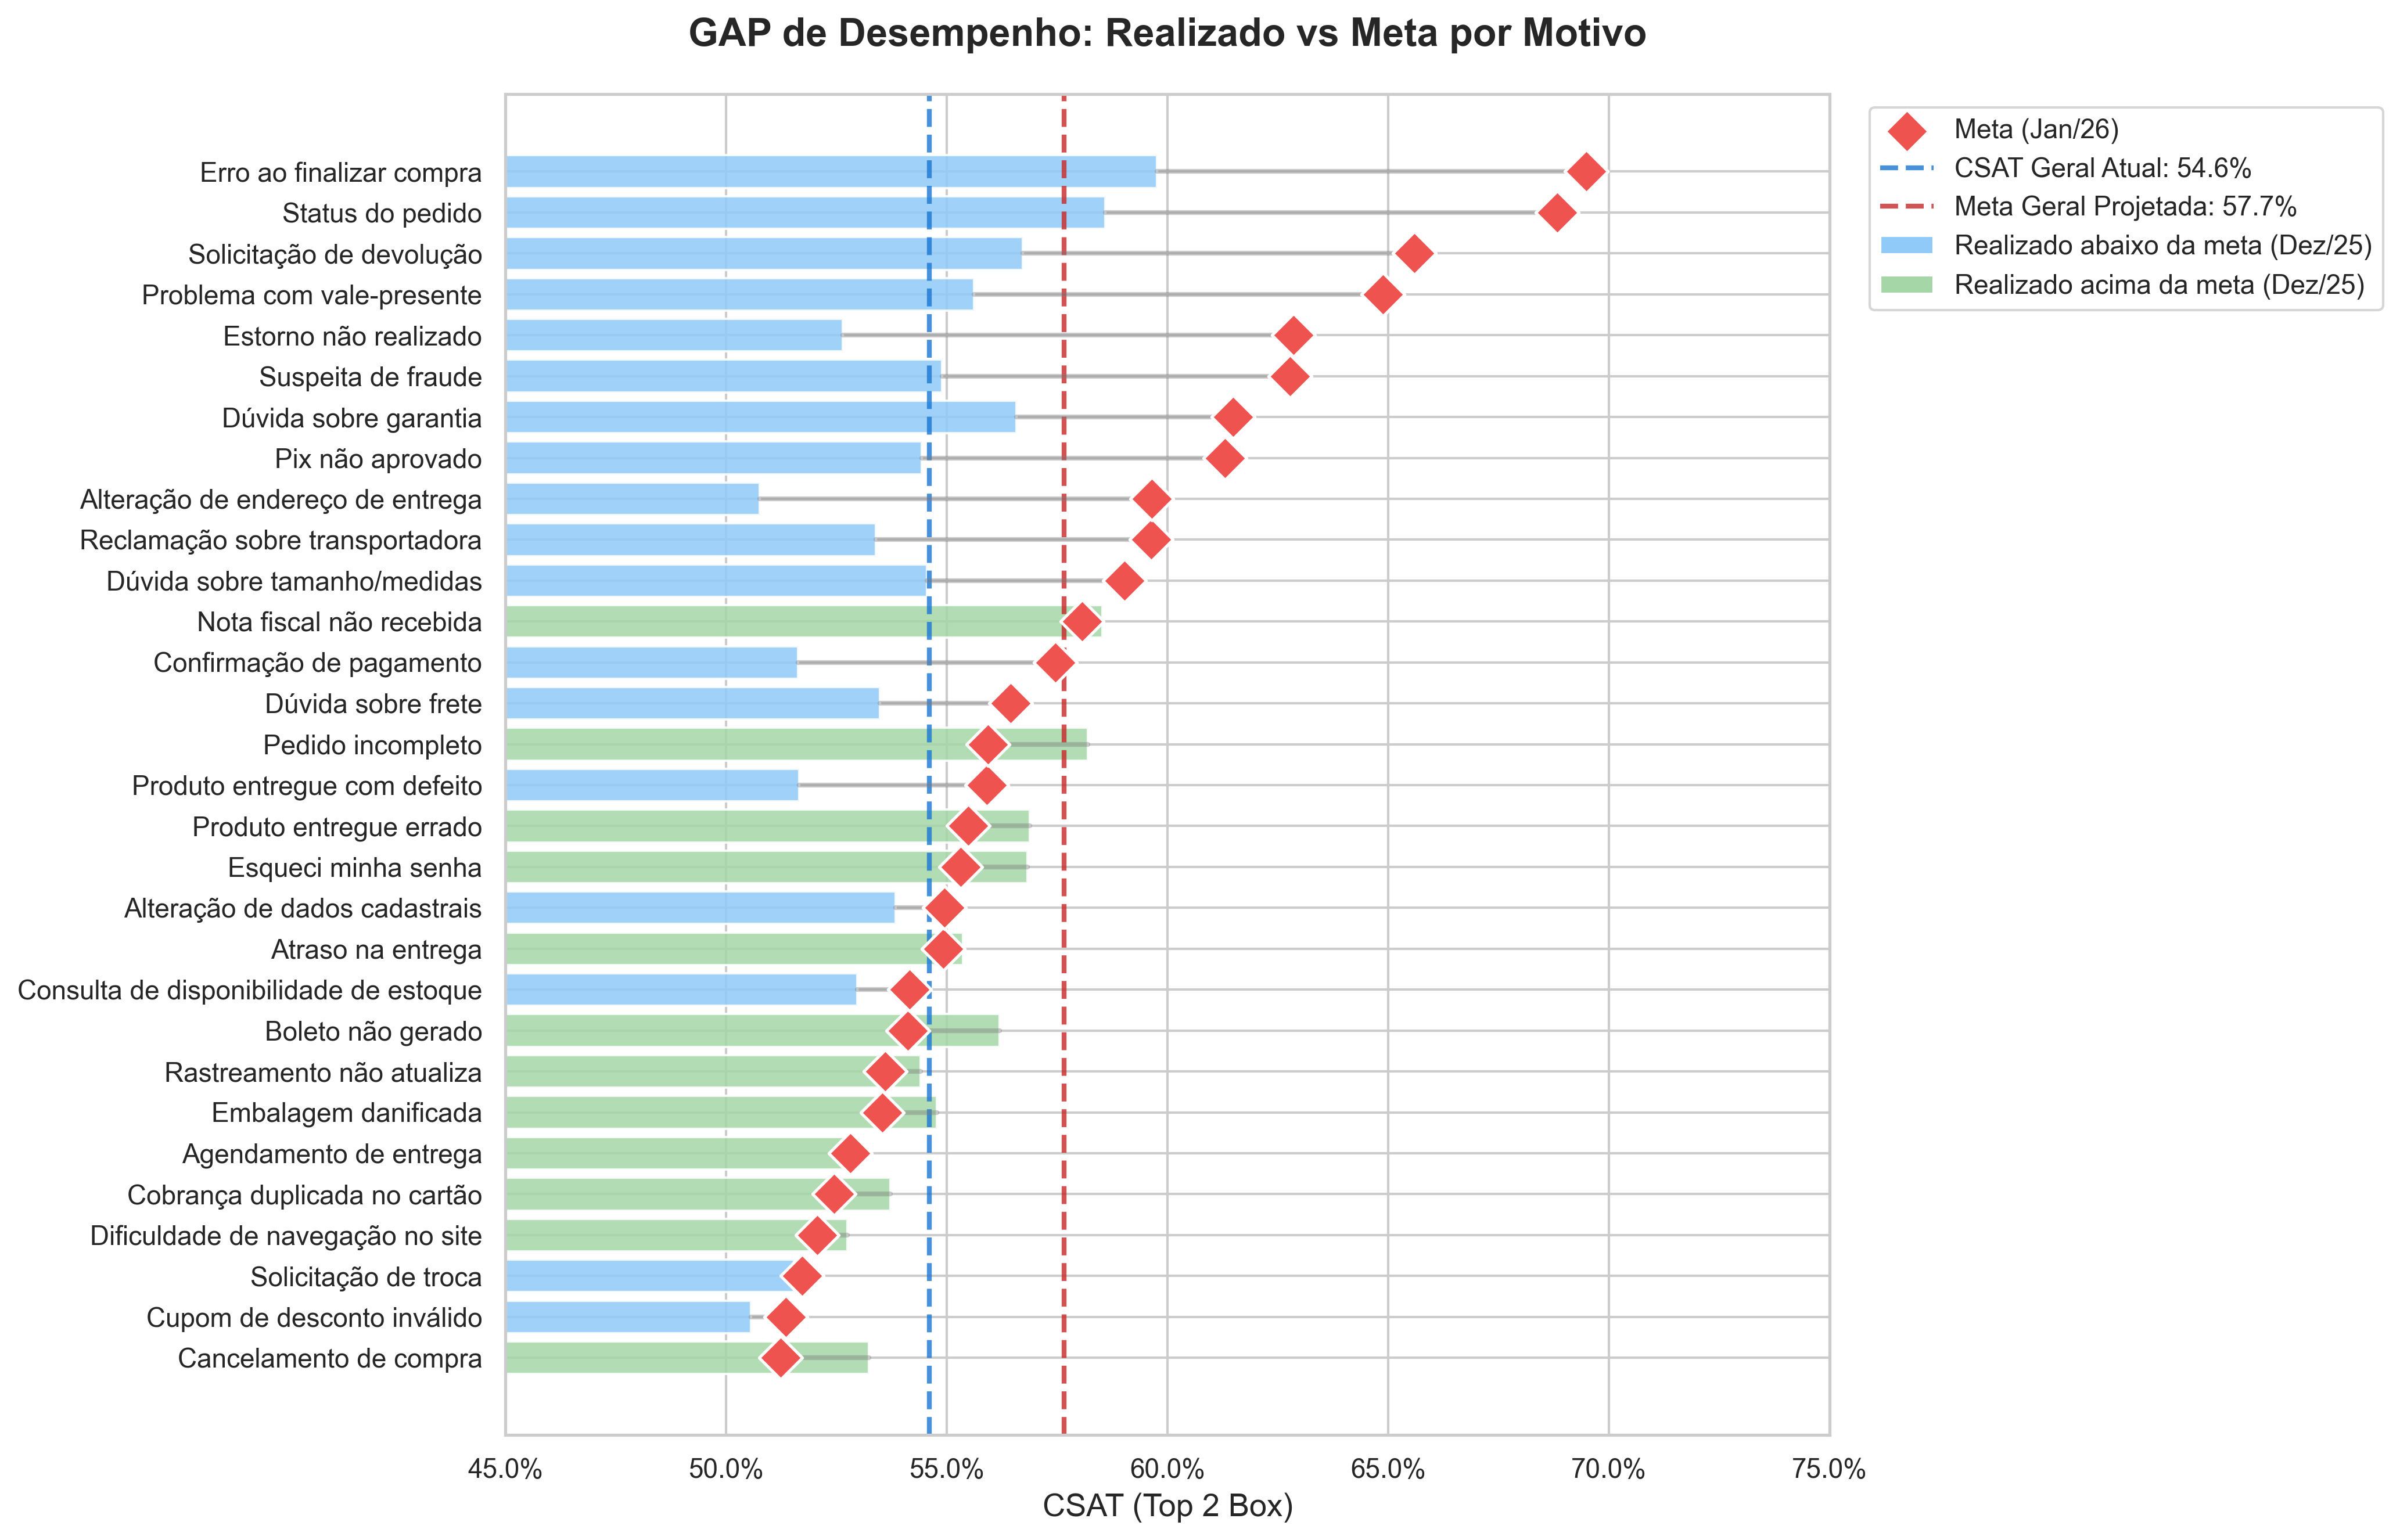

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

dados_grafico = csat_por_motivo.merge(metas_jan, on='motivo_contato', how='inner')

# Ordenar para leitura executiva (piores gaps no topo)
dados_grafico = dados_grafico.sort_values(
    by='meta_motivo', ascending=True
)

# Criar figura
fig, ax = plt.subplots(figsize=(14, 9))

# Identificar quem está abaixo da meta
abaixo_meta = dados_grafico['csat_top2'] < dados_grafico['meta_motivo']

# 1️⃣ Barras horizontais (Realizado)
ax.barh(
    y=dados_grafico['motivo_contato'],
    width=dados_grafico['csat_top2'],
    color=np.where(abaixo_meta, '#90caf9', '#a5d6a7'),
    alpha=0.85
)

# 2️⃣ Conectores do GAP (linha Real → Meta)
for _, row in dados_grafico.iterrows():
    ax.plot(
        [row['csat_top2'], row['meta_motivo']],
        [row['motivo_contato'], row['motivo_contato']],
        color='gray',
        alpha=0.4,
        linewidth=2,
        zorder=5
    )

# 3️⃣ Pontos da Meta
ax.scatter(
    dados_grafico['meta_motivo'],
    dados_grafico['motivo_contato'],
    color='#ef5350',
    s=160,
    marker='D',
    edgecolor='white',
    linewidth=1.2,
    label='Meta (Jan/26)',
    zorder=10
)

# 4️⃣ Linhas de referência globais
ax.axvline(
    x=csat_geral,
    color='#1976d2',
    linestyle='--',
    linewidth=2,
    alpha=0.8,
    label=f'CSAT Geral Atual: {csat_geral:.1%}'
)

ax.axvline(
    x=meta_geral_projetada,
    color='#c62828',
    linestyle='--',
    linewidth=2,
    alpha=0.8,
    label=f'Meta Geral Projetada: {meta_geral_projetada:.1%}'
)

# Formatação
ax.set_title(
    'GAP de Desempenho: Realizado vs Meta por Motivo',
    fontsize=16,
    fontweight='bold',
    pad=20
)

ax.set_xlabel('CSAT (Top 2 Box)', fontsize=13)
ax.set_ylabel('')
ax.set_xlim(0.45, 0.75)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

legend_elements = [
    Patch(facecolor='#90caf9', label='Realizado abaixo da meta (Dez/25)'),
    Patch(facecolor='#a5d6a7', label='Realizado acima da meta (Dez/25)'),
]

handles, labels = ax.get_legend_handles_labels()

# Legenda
ax.legend(
    handles + legend_elements,
    labels + [le.get_label() for le in legend_elements],
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    fontsize=11
)

plt.tight_layout()
plt.savefig('../outputs/grafico_gap_performance.png', dpi=300, bbox_inches='tight')
plt.show()


---

#  6. Análises Visuais Complementares

Criamos 3 visualizações complementares para enriquecer a análise:

1. **Distribuição de Notas CSAT** - Mostra a concentração de avaliações por nota
2. **Reincidência vs Satisfação** - Evidencia o impacto da reincidência no CSAT
3. **Ranking de Prioridade** - Identifica visualmente os ofensores prioritários


## 6.1 Distribuição de Notas CSAT

Este gráfico mostra como as avaliações estão distribuídas entre as notas 1-5, evidenciando o problema de concentração de notas baixas.

In [15]:
# Configurações
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Criar figura
fig, ax = plt.subplots(figsize=(10, 6))

# Contar distribuição
distribuicao = tickets_dez['csat'].value_counts().sort_index()
percentuais = (distribuicao / len(tickets_dez) * 100).round(1)

# Cores gradiente (vermelho -> amarelo -> verde)
cores = ['#ef5350', '#ff7043', '#ffd54f', '#9ccc65', '#66bb6a']

# Criar barras
bars = ax.bar(distribuicao.index, percentuais.values, color=cores, 
              edgecolor='white', linewidth=2, alpha=0.9)

# Adicionar valores nas barras
for i, (bar, val) in enumerate(zip(bars, percentuais.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{val:.1f}%\n({distribuicao.iloc[i]:,})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatação
ax.set_xlabel('Nota CSAT (1-5)', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentual de Avaliações (%)', fontsize=12, fontweight='bold')
ax.set_title('Distribuição de Notas CSAT - Dezembro/2025', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1\n(Muito\nInsatisfeito)', '2\n(Insatisfeito)', 
                    '3\n(Neutro)', '4\n(Satisfeito)', '5\n(Muito\nSatisfeito)'])
ax.set_ylim(0, max(percentuais.values) + 5)
ax.grid(axis='y', alpha=0.3)

# Adicionar linha de referência Top 2 Box
top2_pct = percentuais.iloc[3:].sum()
ax.axhline(y=top2_pct/2, color='#1976d2', linestyle='--', linewidth=2, alpha=0.5)
ax.text(5.3, top2_pct/2, f'Top 2 Box\n{top2_pct:.1f}%', 
        va='center', fontsize=9, color='#1976d2', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/grafico_distribuicao_notas.png', bbox_inches='tight')
plt.show()

print(f"✅ Gráfico salvo: outputs/grafico_distribuicao_notas.png")

✅ Gráfico salvo: outputs/grafico_distribuicao_notas.png


## 6.2 Reincidência vs Satisfação

Análise do impacto da reincidência (número de contatos) na satisfação do cliente.

In [16]:
import numpy as np

# Calcular reincidência
reincidencia = historico_dez.groupby('id_cliente').size().reset_index(name='qtd_contatos')
tickets_reinc = tickets_dez.merge(reincidencia, on='id_cliente', how='left')

# Criar faixas
tickets_reinc['faixa_contatos'] = pd.cut(
    tickets_reinc['qtd_contatos'],
    bins=[0, 1, 2, 3, 5, 100],
    labels=['1', '2', '3', '4-5', '6+']
)

# Calcular CSAT médio por faixa
csat_por_faixa = tickets_reinc.groupby('faixa_contatos', observed=True)['csat'].mean()
volume_por_faixa = tickets_reinc.groupby('faixa_contatos', observed=True).size()

# Criar figura
fig, ax = plt.subplots(figsize=(12, 7))

# Barras
x_pos = np.arange(len(csat_por_faixa))
bars = ax.bar(x_pos, csat_por_faixa.values, color='#1976d2', alpha=0.7, 
              edgecolor='white', linewidth=2, width=0.6)

# Linha de tendência
ax2 = ax.twinx()
line = ax2.plot(x_pos, csat_por_faixa.values, color='#ef5350', 
                marker='o', markersize=10, linewidth=3, label='Tendência')
ax2.set_ylabel('CSAT Médio (Nota 1-5)', fontsize=12, fontweight='bold', color='#ef5350')
ax2.tick_params(axis='y', labelcolor='#ef5350')
ax2.set_ylim(3.0, 3.6)

# Adicionar valores nas barras
for i, (bar, val, vol) in enumerate(zip(bars, csat_por_faixa.values, volume_por_faixa.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height - 0.15,
            f'{val:.2f}\n({vol:,} tickets)',
            ha='center', va='top', fontsize=10, fontweight='bold', color='white')

# Formatação
ax.set_xlabel('Número de Contatos do Cliente', fontsize=12, fontweight='bold')
ax.set_ylabel('CSAT Médio (Nota 1-5)', fontsize=12, fontweight='bold')
ax.set_title('Impacto da Reincidência na Satisfação do Cliente', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(csat_por_faixa.index)
ax.set_ylim(3.0, 3.6)
ax.grid(axis='y', alpha=0.3)

# Legenda
ax.legend(['CSAT Médio'], loc='upper left', fontsize=10)
ax2.legend(['Tendência'], loc='upper right', fontsize=10)

# Anotação
ax.annotate('Queda na satisfação\ncom reincidência', 
            xy=(1, csat_por_faixa.iloc[1]), xytext=(1.5, 3.15),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, color='red', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
ax.annotate('Queda na satisfação\ncom reincidência', 
            xy=(3, csat_por_faixa.iloc[3]), xytext=(1.5, 3.15),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, color='red', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('../outputs/grafico_reincidencia_satisfacao.png', bbox_inches='tight')
plt.show()

print(f"✅ Gráfico salvo: outputs/grafico_reincidencia_satisfacao.png")

✅ Gráfico salvo: outputs/grafico_reincidencia_satisfacao.png


## 6.3 Ranking de Prioridade: Ofensores Críticos

Este gráfico filtra apenas os motivos de **Alta Prioridade** (Alto Volume + Baixo CSAT) e os ordena pela gravidade da nota.
**Como ler este gráfico:**
- **Topo da Lista:** Motivos com as **piores notas de CSAT** (Críticos). Devem ser atacados primeiro.
- **Cor da Barra:** 
    - 🔴 **Vermelho Escuro:** CSAT muito baixo (Situação de Alerta).
    - 🟠 **Laranja:** CSAT baixo, mas menos crítico que os vermelhos.
- **Comprimento da Barra:** Representa o **CSAT Real** (quanto menor, mais curto e mais vermelho).
- **Volume:** Indicado em texto ao lado de cada barra.
**Objetivo:** Atacar os itens do topo (vermelhos) gera o maior impacto positivo na percepção de qualidade do cliente.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# Preparar Dados
if 'prioridade' not in locals():
    dados_temp = csat_por_motivo.merge(metas_jan, on='motivo_contato')
    prioridade = dados_temp[(dados_temp['volume'] > dados_temp['volume'].median()) & 
                            (dados_temp['csat_top2'] < dados_temp['csat_top2'].median())]

# 1. ORDENAÇÃO
df_chart = prioridade.sort_values('csat_top2', ascending=True)

# 2. Configurar Cores
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#ffcc80", "#ef5350", "#b71c1c"]) # Laranja -> Vermelho Escuro

# Normalizar: Mapeia valores aos extremos das cores
norm = mcolors.Normalize(vmin=df_chart['csat_top2'].min(), vmax=df_chart['csat_top2'].max())

# 3. Criar Gráfico
fig, ax = plt.subplots(figsize=(12, 7))

# Aplicar cores (Menor valor = Mais Vermelho = Fim da lista de cores)
cmap_inver = mcolors.LinearSegmentedColormap.from_list("", ["#b71c1c", "#ef5350", "#ffcc80"]) # Vermelho -> Laranja

colors = [cmap_inver(norm(val)) for val in df_chart['csat_top2']]

barras = ax.barh(df_chart['motivo_contato'], df_chart['csat_top2'], color=colors)
ax.set_xlim(0.40, df_chart['csat_top2'].max() * 1.05) 

# 4. Texto
for barra, csat, vol in zip(barras, df_chart['csat_top2'], df_chart['volume']):
    ax.text(barra.get_width() + 0.002, barra.get_y() + barra.get_height()/2, 
            f'{csat:.1%} (Vol: {vol})', 
            va='center', fontweight='bold', color='#b71c1c', fontsize=11)

# 5. Legenda (Barra Lateral)
sm = cm.ScalarMappable(cmap=cmap_inver, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Nota CSAT (Vermelho = Pior)', fontweight='bold')

# Título
ax.set_title('Ranking Prioritário: Os Piores CSATs Primeiro', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('CSAT Score (Top 2 Box)', fontsize=12, fontweight='bold')

sns.despine(left=True, bottom=True)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../outputs/grafico_ranking_csat.png', dpi=300)
plt.show()

print("✅ Gráfico ajustado: Piores notas (Vermelhas) agora estão no TOPO da lista.")

✅ Gráfico ajustado: Piores notas (Vermelhas) agora estão no TOPO da lista.


---

#  RESUMO EXECUTIVO - ANÁLISE DE CSAT (Dezembro/2025)

## Situação Atual
O CSAT geral da companhia em Dezembro de 2025 foi de **54.6%** (metodologia Top 2 Box), indicando que pouco mais da metade dos clientes avaliaram o atendimento positivamente. 

A análise identificou **7 motivos ofensores** que combinam alto volume de contatos com baixa satisfação, sendo os principais:
- **Confirmação de Pagamento** (quebra de confiança - risco de judicialização)
- **Cupom de Desconto Inválido** (falha logística percebida)
- **Dúvida sobre Frete** (fricção na jornada do cliente)

### Correlação com Reincidência
A análise estatística (Spearman) revelou que **clientes reincidentes apresentam CSAT significativamente menor**. Clientes que contatam apenas 1 vez têm satisfação média de 3.44, enquanto reincidentes (2+ contatos) caem para 3.30, evidenciando falha na resolução de primeira chamada (FCR).

---

## Meta para Janeiro/2026

**Meta Projetada Ponderada:** 57.66%  
**GAP necessário:** +3.06 pontos percentuais (+5.6% de crescimento relativo)

### Viabilidade
**MODERADO** - Meta realista com melhorias incrementais. O salto exigido é desafiador mas atingível através da execução rigorosa de ações focadas nos ofensores identificados.

---

## Causas Raízes Identificadas (Análise Semântica - NLP)

Utilizando modelos de linguagem (KeyBERT + Sentence-BERT), foram identificados 3 padrões dominantes nos comentários negativos:

1. **Quebra de Confiança** (21% das queixas em motivos críticos)
   - Menções recorrentes a fraude, cobrança indevida, propaganda enganosa
   - **Risco:** Churn elevado e potencial judicialização

2. **Falha Logística Externa** (22% das queixas)
   - SLAs de transportadoras não cumpridos
   - CX atua como "para-raios" sem poder resolver a causa raiz

3. **Fricção em Autoatendimento** (16% das queixas)
   - Clientes não conseguem resolver sozinhos (app/site)
   - Transbordam frustrados para canais humanos

---

## Plano de Ação Recomendado

###  Prioridade Crítica (30 dias)
1. **Revisar régua de comunicação financeira**
   - Motivos: Confirmação de Pagamento, Estorno não Realizado
   - Ação: Tornar prazos e status mais transparentes

2. **Auditoria de processos com percepção de fraude**
   - Investigar discrepâncias entre expectativa e realidade
   - Ajustar mensagens comerciais para evitar quebra de confiança

###  Médio Prazo (60 dias)
3. **Simplificar UX de fluxos críticos**
   - Motivos: Alteração de Dados Cadastrais, Dúvida sobre Frete
   - Ação: Reduzir etapas, melhorar clareza do autoatendimento

4. **Implementar comunicação preventiva**
   - Avisar cliente proativamente sobre atrasos conhecidos
   - Reduzir volume de contatos reativos

###  Estrutural (90+ dias)
5. **Renegociar SLAs com parceiros logísticos**
   - Apresentar dados de impacto no CSAT
   - Estabelecer penalidades por descumprimento

---

## Conclusão

A meta de **57.66% para Janeiro/2026 é ATINGÍVEL**, desde que:

 As ações de curto prazo sejam executadas imediatamente nos 2 motivos críticos (Confirmação de Pagamento e Rastreamento)

 Haja priorização de recursos para simplificação de UX nos fluxos de maior fricção

 A área de Operações/Logística seja envolvida com dados concretos para ações estruturais

**Recomendação Final:** Iniciar execução imediata do plano, com acompanhamento semanal do CSAT segmentado por motivo para validar efetividade das ações.

---

**Análise realizada por:** Isaque Weber
**Data:** 04/02/2026
**Ferramentas:** Python 3.14, Pandas, Scikit-learn, KeyBERT, Matplotlib